In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original', data_home='./')
X_, y_ = mnist['data'], mnist['target']
X_train, X_test, y_train, y_test = X_[:60000], X_[60000:], y_[:60000], y_[60000:]
shuffle_index = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

## fetch 5 in MNIST datasets

In [3]:
y5_index = np.where(y_ == 5)
X5 = X_[y5_index]
X5.shape

(6313, 784)

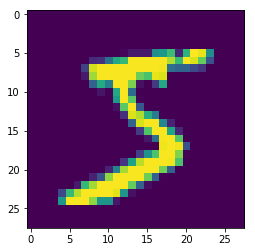

In [281]:
import matplotlib.pyplot as plt
%matplotlib inline
X5 = X5 / 255
X5_train, X5_test = X5[:5000], X5[5000:]
plt.imshow(X5[0].reshape(28, 28))

# GAN

In [415]:
tf.reset_default_graph()

noise_size = 100
n_g_inputs = 28 * 28
n_g_hidden1 = 200
n_g_hidden2 = 100
n_g_hidden3 = 512            #Generatorから生成した画像
n_g_outputs = n_g_inputs

n_d_inputs = 28*28
n_d_hidden1 = 120
n_d_hidden2 = 75
n_d_output = 2

def generate_base(n_g_inputs, batch_size):
    base = tf.random_uniform(shape=(batch_size, noise_size))
    return base

def minibatch(X, batch_size):
    index = np.random.randint(0, len(X), batch_size)
    X_batch = X[index]
    return X_batch

def return_y(batch_size):
    y_0 = np.zeros(batch_size)
    y_1 = np.ones(batch_size)
    y = np.r_[y_0, y_1]
    return tf.constant(y, dtype=tf.int32)

g_X = tf.placeholder(tf.float32, shape=(None, noise_size), name='g_X')
MNIST_X = tf.placeholder(tf.float32, shape=(None, n_g_inputs), name='MNIST_X')


d_y = tf.placeholder(tf.float32, shape=(None), name='d_y')
n_batchies = tf.placeholder(tf.int32, shape=(None), name='n_batchies')
training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate = 0.5

with tf.name_scope('generator'):
    X_drop = tf.layers.dropout(g_X, dropout_rate, training=training)
    g_hidden1 = tf.layers.dense(X_drop, n_g_hidden1, activation=tf.nn.leaky_relu, name='g_hidden1')
    g_drop1 = tf.layers.dropout(g_hidden1, dropout_rate, training=training)
    #g_hidden2 = tf.layers.dense(g_drop1, n_g_hidden2, activation=tf.nn.relu, name='g_hidden2')
    #g_drop2 = tf.layers.dropout(g_hidden2, dropout_rate, training=training)
    #g_hidden3 = tf.layers.dense(g_hidden2, n_g_hidden3, activation=tf.nn.relu, name='g_hidden3')
    g_output = tf.layers.dense(g_drop1, n_g_outputs, activation=tf.nn.sigmoid, name='g_output')
    g_concat = tf.concat([g_output, MNIST_X], 0)
    
with tf.name_scope('discriminator'):

    d_hidden1 = tf.layers.dense(g_concat, n_d_hidden1, activation=tf.nn.leaky_relu, name='d_hidden1')
    #d_hidden2 = tf.layers.dense(d_hidden1, n_d_hidden2, activation=tf.nn.leaky_relu, name='d_hidden2')
    d_output = tf.layers.dense(d_hidden1, n_d_output, name='d_output')

with tf.name_scope('g_loss'):
    g_softmax = tf.nn.softmax(logits=d_output)
    pred = tf.slice(g_softmax, begin=(0, 1), size=(n_batchies, 1))
    g_loss = tf.reduce_mean(tf.log((1 - g_softmax[0:n_batchies, 1]) + 1e-3))

with tf.name_scope('g_train'):
    g_optimizer = tf.train.AdamOptimizer()
    g_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='g_hidden[12]|g_output')
    g_training_op = g_optimizer.minimize(g_loss, var_list=g_train_vars)

with tf.name_scope('d_loss'):
    d_softmax = tf.nn.softmax(logits=d_output)
    y0 = tf.slice(d_softmax, begin=(0, 1), size=(n_batchies, 1))
    y1 = tf.slice(d_softmax, begin=(n_batchies, 1), size=(n_batchies, 1))
    d_loss = -tf.reduce_mean(tf.log(d_softmax[n_batchies: , 1] + 1e-3) + tf.log((1 - d_softmax[0: n_batchies , 1]) + 1e-3))
    
with tf.name_scope('d_train'):
    d_optimizer = tf.train.AdamOptimizer()
    d_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                    scope='d_hidden[12]|d_output')
    d_training_op = d_optimizer.minimize(d_loss, var_list=d_train_vars)
    
with tf.name_scope('d_eval'):
    correct = tf.nn.in_top_k(d_output, tf.cast(d_y, tf.int32), 1)
    acc = tf.reduce_mean(tf.cast(correct, tf.float32))
    

In [416]:
init = tf.global_variables_initializer()

n_epochs = 300
d_batch_size = 100
g_batch_size = 50
test_batch_size = 10
list = []
X5_train.shape[0] // d_batch_size

50

In [417]:
with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for itr in range(X5_train.shape[0] // d_batch_size):
            if itr % 2 == 0:
                d_noise1 = generate_base(n_g_inputs, d_batch_size).eval()
                #MNISTの画像
                X1 = tf.cast(minibatch(X5_train, d_batch_size), tf.float32).eval()
                #y_concat = return_y(d_batch_size).eval()
                sess.run(d_training_op, feed_dict={g_X: d_noise1, MNIST_X: X1, n_batchies: d_batch_size})
            else:
                g_noise1 = generate_base(n_g_inputs, g_batch_size).eval()
                g_noise2 = generate_base(n_g_inputs, g_batch_size).eval()
                gene = g_output.eval(feed_dict={g_X: g_noise1})
                
                sess.run(g_training_op, feed_dict={g_X: g_noise2, MNIST_X: gene, n_batchies: g_batch_size*2, training: True})
            if itr % 100 == 0:
                list.append(gene[0])

        print(epoch)
    finish_noise = generate_base(n_g_inputs, 1).eval()
    finish_generated = g_output.eval(feed_dict={g_X: finish_noise})
    list.append(finish_generated)
    plt.imshow(finish_generated.reshape(28, 28))
        

0
1
2
3
4
5


KeyboardInterrupt: 

In [411]:
len(list)

6

In [414]:
print(list[1].reshape(28, 28))
plt.imshow(list[5].reshape(28, 28))

IndexError: list index out of range

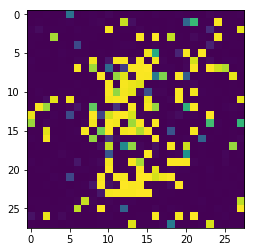

In [384]:
#print(list[584].reshape(28, 28))
plt.imshow(list[1933].reshape(28, 28))

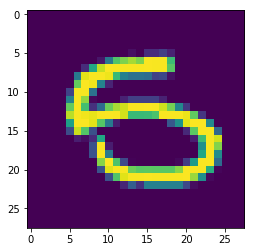

In [262]:
plt.imshow(X5_train[900].reshape(28, 28),cmap='gray')